# Steps in this Notebook

1. Imports
2. Snowflake Setup
3. Local testing wit MLForecast
4. Snowflake testing with MLForecast using UDTF

# Imports

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col

from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType, FloatType, StringType,StructType, StructField

import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
from snowflake.ml.modeling.impute import SimpleImputer

import json
import os
import pandas as pd
from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
connection_parameters = json.load(open('/Users/skhara/Documents/Code/creds.json'))
session = Session.builder.configs(connection_parameters).create()

In [3]:
import os
os.getcwd()

'/Users/skhara/Documents/GitHub/skhara-demos-public/Time Series Demo'

# Snowflake Setup: Create a Database and Schema

We will be using PUBLIC schema.

In [12]:
# Load TS data from Store_Traffic Database into ACCRUENT_TS_FORECASTING DB for testing purposes.
sdf_raw = session.table('TIME_SERIES.SYNTHETIC_DATA.TIME_SERIES_1K')

In [8]:
# Print the Number of Time Series/Pumps that we have to predict
session.sql('SELECT COUNT(DISTINCT SERIES_ID) FROM TIME_SERIES.SYNTHETIC_DATA.TIME_SERIES_1K').collect()

[Row(COUNT(DISTINCT SERIES_ID)=1000)]

In [13]:
sdf_raw.limit(5).to_pandas()

,DATE,SERIES_ID,VALUE
0,2018-01-01,1,119
1,2018-01-02,1,138
2,2018-01-03,1,134
3,2018-01-04,1,124
4,2018-01-05,1,103


In [14]:
sdf_raw.describe().collect()

[Row(SUMMARY='count', SERIES_ID=2046000.0, VALUE=2046000.0),
 Row(SUMMARY='mean', SERIES_ID=500.5, VALUE=124.109512),
 Row(SUMMARY='stddev', SERIES_ID=288.67506080366553, VALUE=35.57537708865502),
 Row(SUMMARY='min', SERIES_ID=1.0, VALUE=44.0),
 Row(SUMMARY='max', SERIES_ID=1000.0, VALUE=246.0)]

# Local Testing

In [15]:
df_data = sdf_raw.filter((F.col("SERIES_ID") == 62)).to_pandas()

# Here onwards copy paste in UDTF
df_data['DATE'] = pd.to_datetime(df_data['DATE'])
df_data.groupby('DATE').sum('VALUE').reset_index()
# df_data = df_data[['DATE','VALUE']]
df_data = df_data.sort_values(by=['DATE']).reset_index(drop=True)

In [16]:
df_data.head()

,DATE,SERIES_ID,VALUE
0,2018-01-01,62,119
1,2018-01-02,62,138
2,2018-01-03,62,133
3,2018-01-04,62,124
4,2018-01-05,62,103


<Axes: xlabel='DATE'>

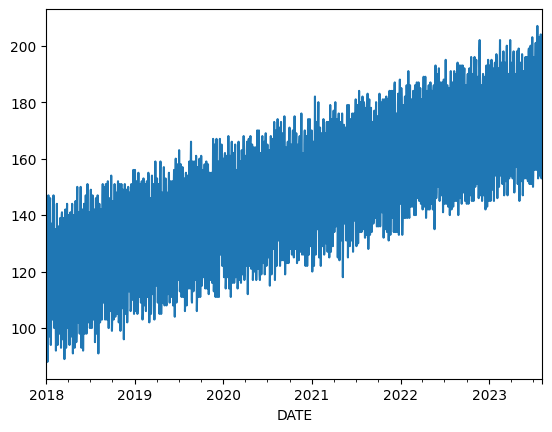

In [17]:
df_data.set_index('DATE')['VALUE'].plot()

### Testing with Nixtla MLForecast

In [18]:
df_mlf = df_data.copy()
df_mlf.columns = ['ds', 'unique_id', 'y']
df_mlf.tail(5)

,ds,unique_id,y
2041,2023-08-04,62,161
2042,2023-08-05,62,153
2043,2023-08-06,62,158
2044,2023-08-07,62,176
2045,2023-08-08,62,192


In [19]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [21]:
fh = 60

In [22]:
fcst = MLForecast(
    models=[LinearRegression(),XGBRegressor(), RandomForestRegressor()],
    freq='D',  # our series has a daily frequency
    lags=[1,7,28,60],
    target_transforms=[Differences([1,365])],
)
fcst.fit(df_mlf.iloc[0:-fh])

MLForecast(models=[LinearRegression, XGBRegressor, RandomForestRegressor], freq=D, lag_features=['lag1', 'lag7', 'lag28', 'lag60'], date_features=[], num_threads=1)

In [23]:
preds = fcst.predict(fh)
preds

,unique_id,ds,LinearRegression,XGBRegressor,RandomForestRegressor
0,62,2023-06-10,147.845917,124.349548,156.660000
1,62,2023-06-11,148.890396,92.540466,159.290000
2,62,2023-06-12,168.738510,89.712257,165.760000
3,62,2023-06-13,182.674347,112.511360,164.710000
4,62,2023-06-14,190.794403,148.006012,167.220000
5,62,2023-06-15,175.847397,166.276917,156.830000
6,62,2023-06-16,149.634323,149.735992,145.650000
7,62,2023-06-17,143.103256,124.418976,153.730000
8,62,2023-06-18,153.316223,98.228195,158.360000
9,62,2023-06-19,161.675171,90.984238,158.600000


In [24]:
df_res = preds.merge(df_mlf, left_on=['ds','unique_id'], right_on = ['ds','unique_id'],how='left')
df_res = df_res.drop('unique_id', axis=1)

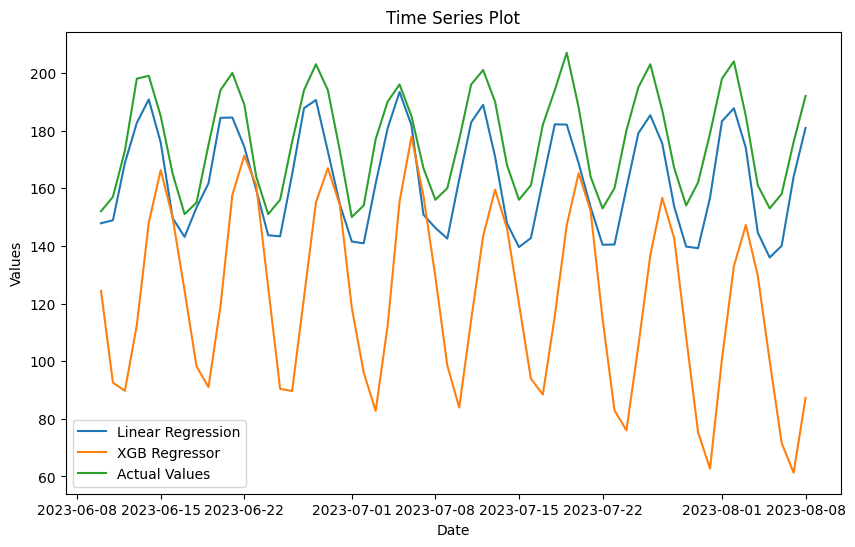

In [25]:
df = df_res.copy()
df.set_index('ds', inplace=True)

# Plotting the time series
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['LinearRegression'], label='Linear Regression')
plt.plot(df.index, df['XGBRegressor'], label='XGB Regressor')
plt.plot(df.index, df['y'], label='Actual Values')

# Adding title and labels
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')

# Adding legend
plt.legend()

# Display the plot
plt.show()


# Creating UDTF for multi-node parallelized model training

In [27]:
session.use_database('TIME_SERIES')
session.use_schema('SYNTHETIC_DATA')

In [28]:
schema = T.StructType([
    T.StructField("ID", T.IntegerType()),
    T.StructField("TIMESTAMP", T.DateType()),
    T.StructField("LINREG", T.FloatType()),
    T.StructField("XGB", T.FloatType()),
    T.StructField("TRAIN_START", T.DateType()),
    T.StructField("TRAIN_END", T.DateType()),
    T.StructField("FORECAST_HORIZON", T.IntegerType())
                  ])

@F.udtf(output_schema = schema,
        input_types = [T.VariantType()],
        name = "TSF_MLFORECAST", is_permanent=True, stage_location= "@DEMO_DB.PUBLIC.ML_MODELS", session=session,
        packages=['pandas', 'mlforecast' ,'xgboost', 'scikit-learn'],
        replace=True
       )

class forecast:
    def __init__(self):
        self.rows=[]
        self.dfs=[]
    
    def process(self, data):
        self.rows.append(data)

        # Merge rows into a dataframe
        if len(self.rows) >= 16000:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Merge dataframes into a single dataframe
        # Minimizes memory footprint
        if len(self.dfs) >= 100:
            merged_df = pd.concat(self.dfs)
            self.dfs = [merged_df]

        yield None
    
    def end_partition(self):
        # Merge any remaining rows
        from mlforecast import MLForecast
        from mlforecast.target_transforms import Differences
        from xgboost import XGBRegressor
        from sklearn.linear_model import LinearRegression

        if len(self.rows) > 0:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []

        # Process Input
        df_input = pd.concat(self.dfs)
        df_input['DATE'] = pd.to_datetime(df_input['DATE'])
        df_input.groupby(['DATE','SERIES_ID']).sum('VALUE').reset_index()
        df_input = df_input[['DATE','SERIES_ID','VALUE']]
        df_input.columns = ['ds','unique_id','y']

        #Train + Forecast Length
        train_length = 600
        fh = 30 # Forecast Horizon
        train_end = max(df_input['ds'])
        train_start = train_end - pd.Timedelta(days = 600)
        
        df_input = df_input.loc[(df_input['ds'] >= train_start) &
                                (df_input['ds'] < train_end)].reset_index(drop=True)

        
        fcst = MLForecast(models=[LinearRegression(),XGBRegressor()],
                          freq='D',
                          lags=[1,7,28,60],
                          target_transforms=[Differences([1])])
        
        fcst.fit(df_mlf.iloc[0:-fh])

        ts_forecast = fcst.predict(fh)
        
        # Processing
        ts_forecast.columns = ['ID','TIMESTAMP','LINREG','XGB']
        ts_forecast['TRAIN_START'] = train_start
        ts_forecast['TRAIN_END'] = train_end
        ts_forecast['FORECAST_HORIZON'] = fh

        yield from ts_forecast.itertuples(index=False, name=None) 

The version of package 'mlforecast' in the local environment is 0.11.2, which does not fit the criteria for the requirement 'mlforecast'. Your UDF might not work when the package version is different between the server and your local environment.


In [29]:
df = session.table('TIME_SERIES.SYNTHETIC_DATA.TIME_SERIES_1K') \
        .with_column('ROW', F.object_construct_keep_null('*')) \
        .select(F.col('SERIES_ID'), F.col('ROW'))

store_forecast_test = F.table_function("TSF_MLFORECAST")

variant_column = F.parse_json(df.col('ROW').cast(T.VariantType()))

forecast = df.select(
                F.col('SERIES_ID'), 
                store_forecast_test(variant_column).over(partition_by=['SERIES_ID'])
                )

forecast = forecast.with_column('FORECAST_DATETIME', F.current_timestamp())
forecast.write.save_as_table("DEMO_DB.PUBLIC.FORECAST_USING_MLFORECAST", mode="append")

In [30]:
sdf_ref = session.table('DEMO_DB.PUBLIC.FORECAST_USING_MLFORECAST')
sdf_ref.limit(5).to_pandas()

,SERIES_ID,ID,TIMESTAMP,LINREG,XGB,TRAIN_START,TRAIN_END,FORECAST_HORIZON,FORECAST_DATETIME
0,344,62,2023-07-10,177.673706,178.250305,2021-12-16,2023-08-08,30,2024-02-23 09:32:47.996000-08:00
1,344,62,2023-07-11,197.565735,196.981827,2021-12-16,2023-08-08,30,2024-02-23 09:32:47.996000-08:00
2,344,62,2023-07-12,200.064362,199.370331,2021-12-16,2023-08-08,30,2024-02-23 09:32:47.996000-08:00
3,344,62,2023-07-13,187.862564,188.086197,2021-12-16,2023-08-08,30,2024-02-23 09:32:47.996000-08:00
4,344,62,2023-07-14,169.951813,166.865524,2021-12-16,2023-08-08,30,2024-02-23 09:32:47.996000-08:00


# Deployment
Two options -
1. Create a task using SQL
2. Create a task using Task API


In [ ]:
def run_forecasts(session:session):
    df = session.table('TIME_SERIES.SYNTHETIC_DATA.TIME_SERIES_1K') \
            .with_column('ROW', F.object_construct_keep_null('*')) \
            .select(F.col('SERIES_ID'), F.col('ROW'))

    store_forecast_test = F.table_function("TSF_MLFORECAST")

    variant_column = F.parse_json(df.col('ROW').cast(T.VariantType()))

    forecast = df.select(
                    F.col('SERIES_ID'), 
                    store_forecast_test(variant_column).over(partition_by=['SERIES_ID'])
                    )

    forecast = forecast.with_column('FORECAST_DATETIME', F.current_timestamp())
    forecast.write.save_as_table("DEMO_DB.PUBLIC.FORECAST_USING_MLFORECAST", mode="append")

In [ ]:
# Create Task Object
api_root = Root(session)
schema = api_root.databases['RECOMMENDER_SYSTEMS'].schemas['COLLABORATIVE_FILTERING_ALS']
tasks = schema.tasks

# Create the Task
task1_entity = Task(
    "TS_FORECASTS",
    definition = StoredProcedureCall(run_forecasts,
                                     stage_location="@ML_MODELS",
                                     packages=["snowflake-snowpark-python","snowflake-ml-python", "regex"]),
    warehouse = connection_parameters['warehouse'],
    schedule = timedelta(days=1))

task1 = tasks.create(task1_entity, mode="orReplace")
task1.resume()